In [34]:
%matplotlib inline

import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys

In [35]:
import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__))

matplotlib: 3.0.2


In [36]:
CONVERTED_DATABASE_NAME = '/home/ubuntu/HeLa_20KInt-rt-4400-4520/HeLa_20KInt.sqlite'

In [37]:
# feature_list_filename = "/Users/darylwilding-mcbride/Downloads/features/HeLa_20KInt-feature-list.csv"
feature_list_filename = "/home/ubuntu/HeLa_20KInt-rt-4400-4520/HeLa_20KInt-feature-list.csv"
feature_list_df = pd.read_csv(feature_list_filename)

In [38]:
# allpeptides_df = pd.read_csv('/Users/darylwilding-mcbride/Downloads/maxquant/allPeptides.txt', sep='\t')
allpeptides_df = pd.read_csv('/home/ubuntu/maxquant_results/txt/allPeptides.txt', sep='\t')

In [39]:
len(allpeptides_df)

328862

In [40]:
allpeptides_df.head()

,Raw file,Charge,m/z,Mass,Resolution,Number of data points,Number of frames,Number of isotopic peaks,Isotope correlation,Mass fractional part,...,Min frame index,Max frame index,Ion mobility index,Ion mobility index length,Ion mobility index length (FWHM),Intensity,Intensities,Number of pasef MS/MS,Pasef MS/MS IDs,MS/MS scan number
0,HeLa_20KInt_2KIT_Slot1-46_01_1179,1,326.37791,325.37063,24329.390330,3048,20,2,0.999609,0.370635,...,5137,5156,363,54,27,31429.0,NaN,0,NaN,NaN
1,HeLa_20KInt_2KIT_Slot1-46_01_1179,1,312.32607,311.31879,24234.331350,19515,75,2,0.992528,0.318792,...,5351,5425,501,51,21,81118.0,NaN,0,NaN,NaN
2,HeLa_20KInt_2KIT_Slot1-46_01_1179,1,316.28438,315.27711,24449.285122,706,7,2,0.999514,0.277105,...,5112,5118,549,75,27,36051.0,NaN,0,NaN,NaN
3,HeLa_20KInt_2KIT_Slot1-46_01_1179,1,307.09608,306.08880,24469.582565,7633,22,2,0.998656,0.088801,...,4935,4956,651,111,30,295110.0,NaN,0,NaN,NaN
4,HeLa_20KInt_2KIT_Slot1-46_01_1179,1,316.16858,315.16130,24514.638897,108,3,2,0.999752,0.161303,...,5032,5034,645,21,18,7543.2,NaN,0,NaN,NaN


In [41]:
allpeptides_df.columns

Index(['Raw file', 'Charge', 'm/z', 'Mass', 'Resolution',
       'Number of data points', 'Number of frames', 'Number of isotopic peaks',
       'Isotope correlation', 'Mass fractional part', 'Mass deficit',
       'Retention time', 'Retention length', 'Retention length (FWHM)',
       'Min frame index', 'Max frame index', 'Ion mobility index',
       'Ion mobility index length', 'Ion mobility index length (FWHM)',
       'Intensity', 'Intensities', 'Number of pasef MS/MS', 'Pasef MS/MS IDs',
       'MS/MS scan number'],
      dtype='object')

In [42]:
allpeptides_df.rename(columns={'Number of isotopic peaks': 'isotope_count', 'm/z': 'mz', 'Intensity': 'intensity', 'Retention time': 'rt', 'Charge': 'charge'}, inplace=True)

In [43]:
feature_list_df.head()

,feature_id,charge_state,monoisotopic_mass,feature_centroid_scan,feature_centroid_rt,feature_centroid_mz,feature_start_rt,feature_end_rt,feature_scan_lower,feature_scan_upper,...,base_peak_scan_lower,base_peak_scan_upper,base_peak_centroid_rt,base_peak_std_dev_rt,base_peak_rt_lower,base_peak_rt_upper,base_peak_centroid_mz,base_peak_std_dev_mz,base_peak_mz_lower,base_peak_mz_upper
0,1,2,1789.903994,381.285143,4434.094136,896.320994,4426.643707,4449.083986,370,390,...,370,390,4431.407063,3.171312,4426.643707,4449.083986,895.957460,0.003420,895.917833,895.998069
1,2,2,1789.904087,437.863193,4433.852857,896.403946,4431.368938,4441.995797,426,446,...,426,446,4434.439628,2.122600,4431.368938,4441.995797,895.958320,0.004362,895.908394,895.993349
2,3,2,1789.898753,366.914385,4433.349076,896.323500,4424.280661,4439.635599,357,377,...,357,377,4435.790388,2.394142,4431.368938,4439.635599,895.955991,0.002943,895.917833,895.993349
3,4,2,1635.899234,473.844696,4456.443861,819.319922,4443.177867,4465.608514,463,483,...,463,483,4456.250979,3.275733,4443.177867,4465.608514,819.458767,0.005895,819.419878,819.496613
4,5,2,1505.746788,455.546172,4442.617238,754.211545,4433.733502,4453.805803,447,467,...,447,467,4442.781754,3.337274,4433.733502,4453.805803,753.881095,0.007275,753.845012,753.914282


In [44]:
feature_list_df.columns

Index(['feature_id', 'charge_state', 'monoisotopic_mass',
       'feature_centroid_scan', 'feature_centroid_rt', 'feature_centroid_mz',
       'feature_start_rt', 'feature_end_rt', 'feature_scan_lower',
       'feature_scan_upper', 'feature_summed_intensity', 'isotope_count',
       'mono_peak_id', 'mono_peak_centroid_scan', 'mono_peak_std_dev_scan',
       'mono_peak_scan_lower', 'mono_peak_scan_upper', 'mono_peak_centroid_rt',
       'mono_peak_std_dev_rt', 'mono_peak_rt_lower', 'mono_peak_rt_upper',
       'mono_peak_centroid_mz', 'mono_peak_std_dev_mz', 'mono_peak_mz_lower',
       'mono_peak_mz_upper', 'base_peak_id', 'base_peak_centroid_scan',
       'base_peak_std_dev_scan', 'base_peak_scan_lower',
       'base_peak_scan_upper', 'base_peak_centroid_rt', 'base_peak_std_dev_rt',
       'base_peak_rt_lower', 'base_peak_rt_upper', 'base_peak_centroid_mz',
       'base_peak_std_dev_mz', 'base_peak_mz_lower', 'base_peak_mz_upper'],
      dtype='object')

In [45]:
feature_list_subset_df = feature_list_df[["feature_id","mono_peak_centroid_mz","mono_peak_centroid_rt","mono_peak_centroid_scan","monoisotopic_mass","feature_summed_intensity","charge_state"]].copy()

In [46]:
feature_list_subset_df.sort_values(by=['feature_summed_intensity'], ascending=False, inplace=True)

In [47]:
allpeptides_subset_df = allpeptides_df[["mz","intensity","charge","rt","Ion mobility index"]].copy()

In [48]:
allpeptides_subset_df.sort_values(by=['intensity'], ascending=False).head()

,mz,intensity,charge,rt,Ion mobility index
273238,895.95670,26707000.0,2,4432.552,363
195754,714.35058,25183000.0,1,3224.585,183
155746,655.86110,23453000.0,2,4728.970,474
206499,706.40506,21142000.0,2,3332.142,540
311960,1108.04640,19726000.0,2,4999.334,204


In [49]:
allpeptides_subset_df = allpeptides_subset_df[allpeptides_subset_df.intensity.notnull()].copy()

allpeptides_subset_df.sort_values(by=['intensity'], ascending=False, inplace=True)
allpeptides_subset_df["mq_feature_id"] = np.arange(start=1, stop=len(allpeptides_subset_df)+1)

Vary PPM to find the number of MQ matches for each feature

Vary RT delta to find the number of MQ matches for each feature

For each MQ feature, find the matches with pipeline features

Work out the tolerances

In [50]:
df = []

MZ_TOLERANCE_PPM = 5
MZ_TOLERANCE_PERCENT = MZ_TOLERANCE_PPM * 10**-4 
RT_TOLERANCE_SECS = 6

allpeptides_subset_df["mz_delta"] = allpeptides_subset_df.mz * MZ_TOLERANCE_PERCENT / 100
allpeptides_subset_df["mz_upper"] = allpeptides_subset_df.mz + allpeptides_subset_df.mz_delta
allpeptides_subset_df["mz_lower"] = allpeptides_subset_df.mz - allpeptides_subset_df.mz_delta

allpeptides_subset_df["rt_upper"] = allpeptides_subset_df.rt + RT_TOLERANCE_SECS
allpeptides_subset_df["rt_lower"] = allpeptides_subset_df.rt - RT_TOLERANCE_SECS

Plot the number of matches

In [51]:
MQ_FEATURE_ID = 8

In [52]:
mq_feature_df = allpeptides_subset_df[allpeptides_subset_df.mq_feature_id == MQ_FEATURE_ID].iloc[0]

mz_lower = mq_feature_df.mz_lower
mz_upper = mq_feature_df.mz_upper
rt_lower = mq_feature_df.rt_lower
rt_upper = mq_feature_df.rt_upper
charge = mq_feature_df.charge

matches_df = feature_list_subset_df[
                            (
                                (mz_lower <= feature_list_subset_df.mono_peak_centroid_mz) &
                                (mz_upper >= feature_list_subset_df.mono_peak_centroid_mz)
                            ) &
                            (
                                (rt_lower <= feature_list_subset_df.mono_peak_centroid_rt) &
                                (rt_upper >= feature_list_subset_df.mono_peak_centroid_rt)
                            ) &
                            (
                                charge == feature_list_subset_df.charge_state
                            )
]

In [53]:
mq_feature_rt = mq_feature_df.rt
mq_feature_rt

4457.345

In [54]:
matches_df

,feature_id,mono_peak_centroid_mz,mono_peak_centroid_rt,mono_peak_centroid_scan,monoisotopic_mass,feature_summed_intensity,charge_state
48,49,877.900461,4456.332813,344.105772,1753.785056,4285945,2
29,30,877.902112,4451.781776,398.848474,1753.786393,2664640,2
118,119,877.903410,4458.975043,393.261799,1753.790511,1796978,2
247,250,877.904855,4456.155166,457.796594,1753.794699,1309916,2
170,171,877.901654,4454.710012,340.911866,1753.786458,1261489,2
2179,2228,877.904703,4453.422274,481.915426,1753.794747,78988,2
4196,4351,877.900884,4455.324746,504.888784,1753.786535,33696,2


In [55]:
feature_ids = matches_df.feature_id.tolist()
feature_ids

[49, 30, 119, 250, 171, 2228, 4351]

In [56]:
feature_raw_points_df_list = []
db_conn = sqlite3.connect(CONVERTED_DATABASE_NAME)
for feature_id in feature_ids:
    df = pd.read_sql_query("select * from frames where (frame_id,point_id) in (select raw_frame_id,raw_point_id from raw_summed_join where (summed_frame_id,summed_point_id) in (select frame_id,point_id from summed_frames where (frame_id,peak_id) in (select frame_id,peak_id from peaks where (frame_id,cluster_id) in (select frame_id,cluster_id from clusters where feature_id=={}))))".format(feature_id), db_conn)
    feature_raw_points_df_list.append((df))
db_conn.close()

In [57]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
# Rescale to values between 0 and 1 
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)

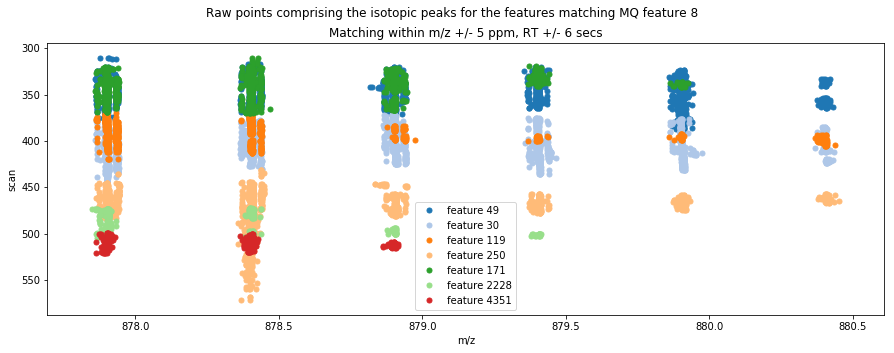

In [58]:
f, ax = plt.subplots()
for idx,feature_id in enumerate(feature_ids):
    feature_raw_points_df = feature_raw_points_df_list[idx]
    ax.plot(feature_raw_points_df.mz, feature_raw_points_df.scan, marker='o', color=tableau20[idx], linestyle='', ms=5, label="feature {}".format(feature_id))
plt.legend(loc='best')
plt.xlabel('m/z')
plt.ylabel('scan')
plt.gca().invert_yaxis()
f.set_figheight(5)
f.set_figwidth(15)
plt.suptitle('Raw points comprising the isotopic peaks for the features matching MQ feature {}'.format(MQ_FEATURE_ID))
plt.title('Matching within m/z +/- {} ppm, RT +/- {} secs'.format(MZ_TOLERANCE_PPM, RT_TOLERANCE_SECS))
plt.margins(0.06)
plt.show()

In [59]:
snapshot_feature_df_list = []
for idx,feature_id in enumerate(feature_ids):
    df = feature_raw_points_df_list[idx]
    df = df[(df.retention_time_secs >= mq_feature_rt-0.5) & (df.retention_time_secs <= mq_feature_rt+0.5)]
    snapshot_feature_df_list.append((df))

In [60]:
len(snapshot_feature_df_list)

7

In [61]:
pd.__version__

'0.24.0'

In [62]:
import pickle

In [63]:
with open("/home/ubuntu/snapshot_mq_feature_{}.pickle".format(MQ_FEATURE_ID), "wb") as output_file:
    pickle.dump(snapshot_feature_df_list, output_file)

In [64]:
with open("/home/ubuntu/full_mq_feature_{}.pickle".format(MQ_FEATURE_ID), "wb") as output_file:
    pickle.dump(feature_raw_points_df_list, output_file)

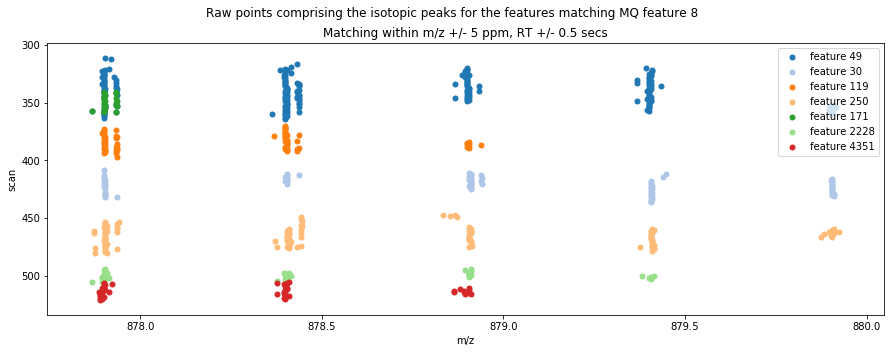

In [65]:
f, ax = plt.subplots()
for idx,feature_id in enumerate(feature_ids):
    df = snapshot_feature_df_list[idx]
    if len(df) > 0:
        ax.plot(df.mz, df.scan, marker='o', color=tableau20[idx], linestyle='', ms=5, label="feature {}".format(feature_id))
plt.legend(loc='best')
plt.xlabel('m/z')
plt.ylabel('scan')
plt.gca().invert_yaxis()
f.set_figheight(5)
f.set_figwidth(15)
plt.suptitle('Raw points comprising the isotopic peaks for the features matching MQ feature {}'.format(MQ_FEATURE_ID))
plt.title('Matching within m/z +/- {} ppm, RT +/- 0.5 secs'.format(MZ_TOLERANCE_PPM, RT_TOLERANCE_SECS))
plt.margins(0.06)
plt.show()

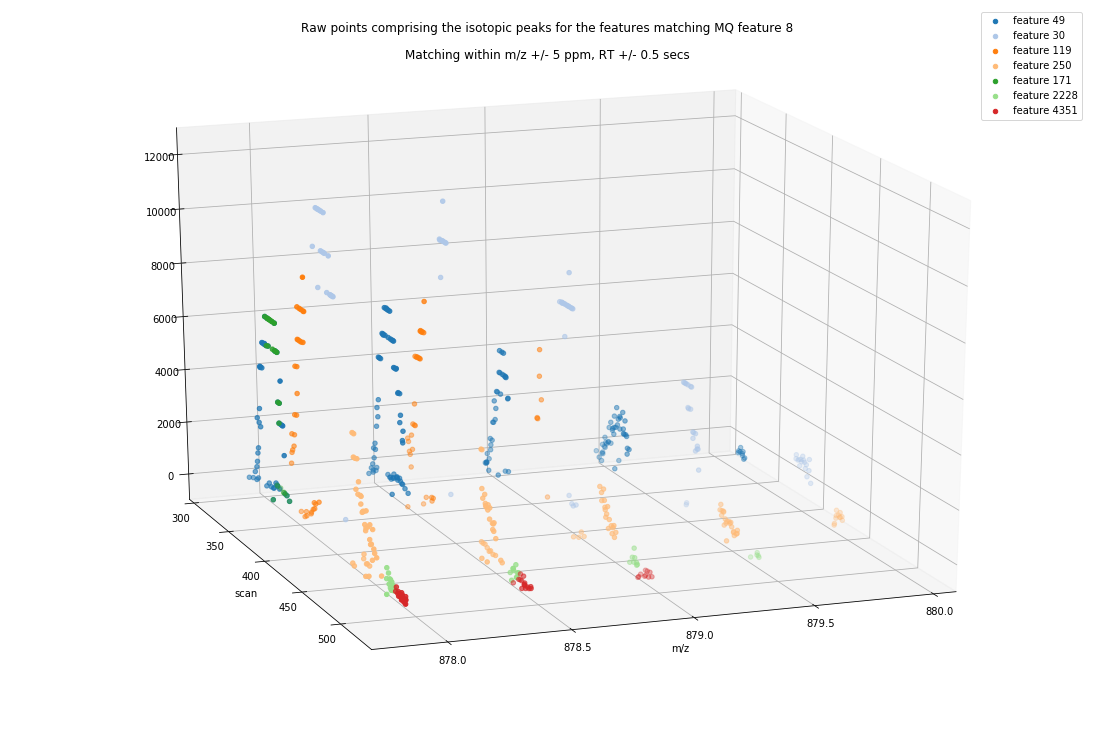

In [66]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(15)

ax = Axes3D(fig)

ax.elev = 20.0
ax.azim = 250.0
ax.dist = 10.0

plt.gca().invert_yaxis()
plt.xlabel('m/z')
plt.ylabel('scan')

for idx,feature_id in enumerate(feature_ids):
    df = snapshot_feature_df_list[idx]
    if len(df) > 0:
        ax.scatter(df.mz, df.scan, df.intensity, c=[tableau20[idx]], label="feature {}".format(feature_id))
plt.legend(loc='best')

plt.suptitle('Raw points comprising the isotopic peaks for the features matching MQ feature {}'.format(MQ_FEATURE_ID))
plt.title('Matching within m/z +/- {} ppm, RT +/- 0.5 secs'.format(MZ_TOLERANCE_PPM, RT_TOLERANCE_SECS))
plt.margins(0.06)
plt.show()